# Segement Anything Model by Meta AI

In [55]:
#https://github.com/facebookresearch/segment-anything?tab=readme-ov-file

In [42]:
import os
HOME = os.getcwd()
print("HOME:", HOME)

HOME: /Users/santiagowon/Dropbox/Santiago/01. Maestria/Tesis/10_Project


In [ ]:
%pip install git+https://github.com/facebookresearch/segment-anything.git

In [ ]:
%pip install opencv-python pycocotools matplotlib onnxruntime onnx

# Automatically generating object masks with SAM

In [ ]:
# https://github.com/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb

In [61]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [62]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

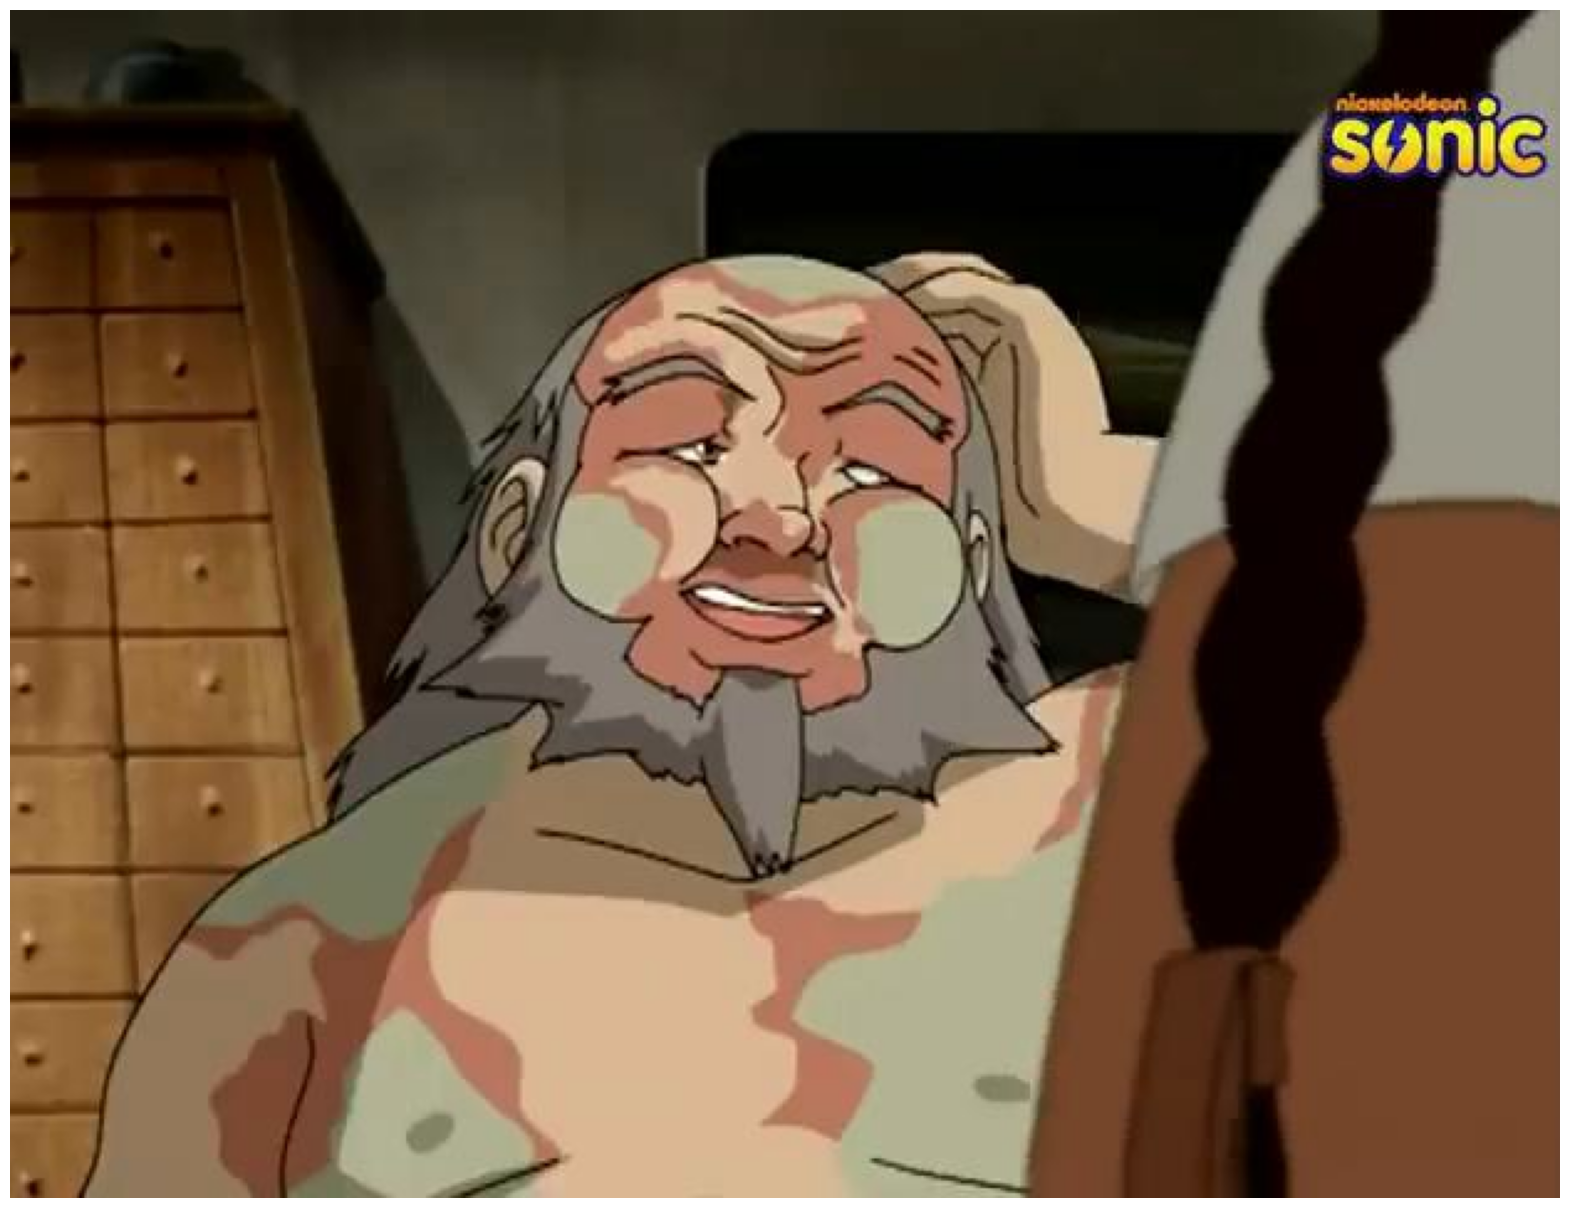

In [183]:
image = cv2.imread('/Users/santiagowon/Dropbox/Santiago/01. Maestria/Tesis/11_Project_Analysed_DB/1 summary missing/Avatar_The_Last_Airbender/scenes_output/scene_137_frame_13123.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

In [189]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/Users/santiagowon/Dropbox/Santiago/01. Maestria/Tesis/10_Project/SAM Model Weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

Sam(
  (image_encoder): ImageEncoderViT(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 1280, kernel_size=(16, 16), stride=(16, 16))
    )
    (blocks): ModuleList(
      (0-31): 32 x Block(
        (norm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=1280, out_features=3840, bias=True)
          (proj): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (norm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (lin1): Linear(in_features=1280, out_features=5120, bias=True)
          (lin2): Linear(in_features=5120, out_features=1280, bias=True)
          (act): GELU(approximate='none')
        )
      )
    )
    (neck): Sequential(
      (0): Conv2d(1280, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): LayerNorm2d()
      (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (3): LayerNorm2d

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:

segmentation : the mask
area : the area of the mask in pixels
bbox : the boundary box of the mask in XYWH format
predicted_iou : the model's own prediction for the quality of the mask
point_coords : the sampled input point that generated this mask
stability_score : an additional measure of mask quality
crop_box : the crop of the image used to generate this mask in XYWH format

In [72]:
# masks = mask_generator.generate(image)

In [185]:
mask_generator_6 = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=32,  # Slightly higher point density to capture more detail
    pred_iou_thresh=0.90,  
    stability_score_thresh=0.92,  
    crop_n_layers=0,  
    crop_n_points_downscale_factor=2,  
    min_mask_region_area=100  # Allow larger regions to capture key areas
)


In [186]:
masks6 = mask_generator_6.generate(image)

In [187]:
len(masks6)

75

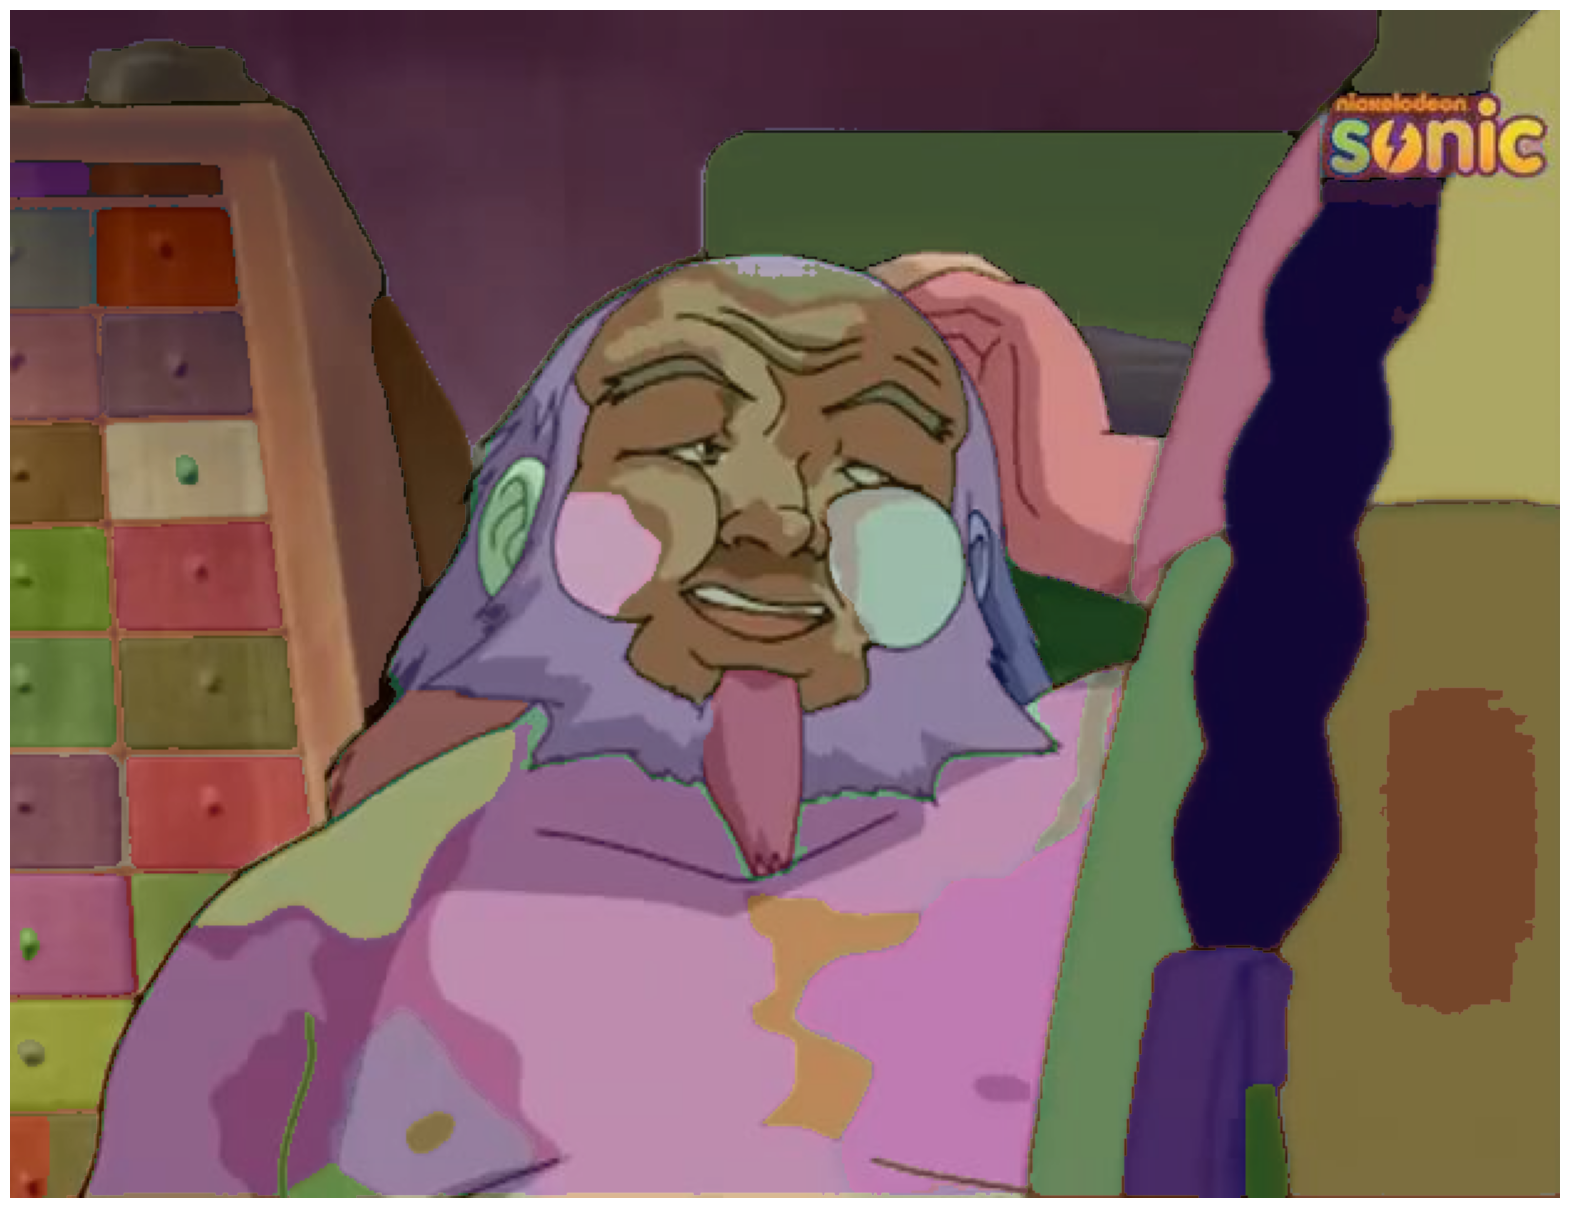

Number of masks: 75, Rows: 13, Cols: 6


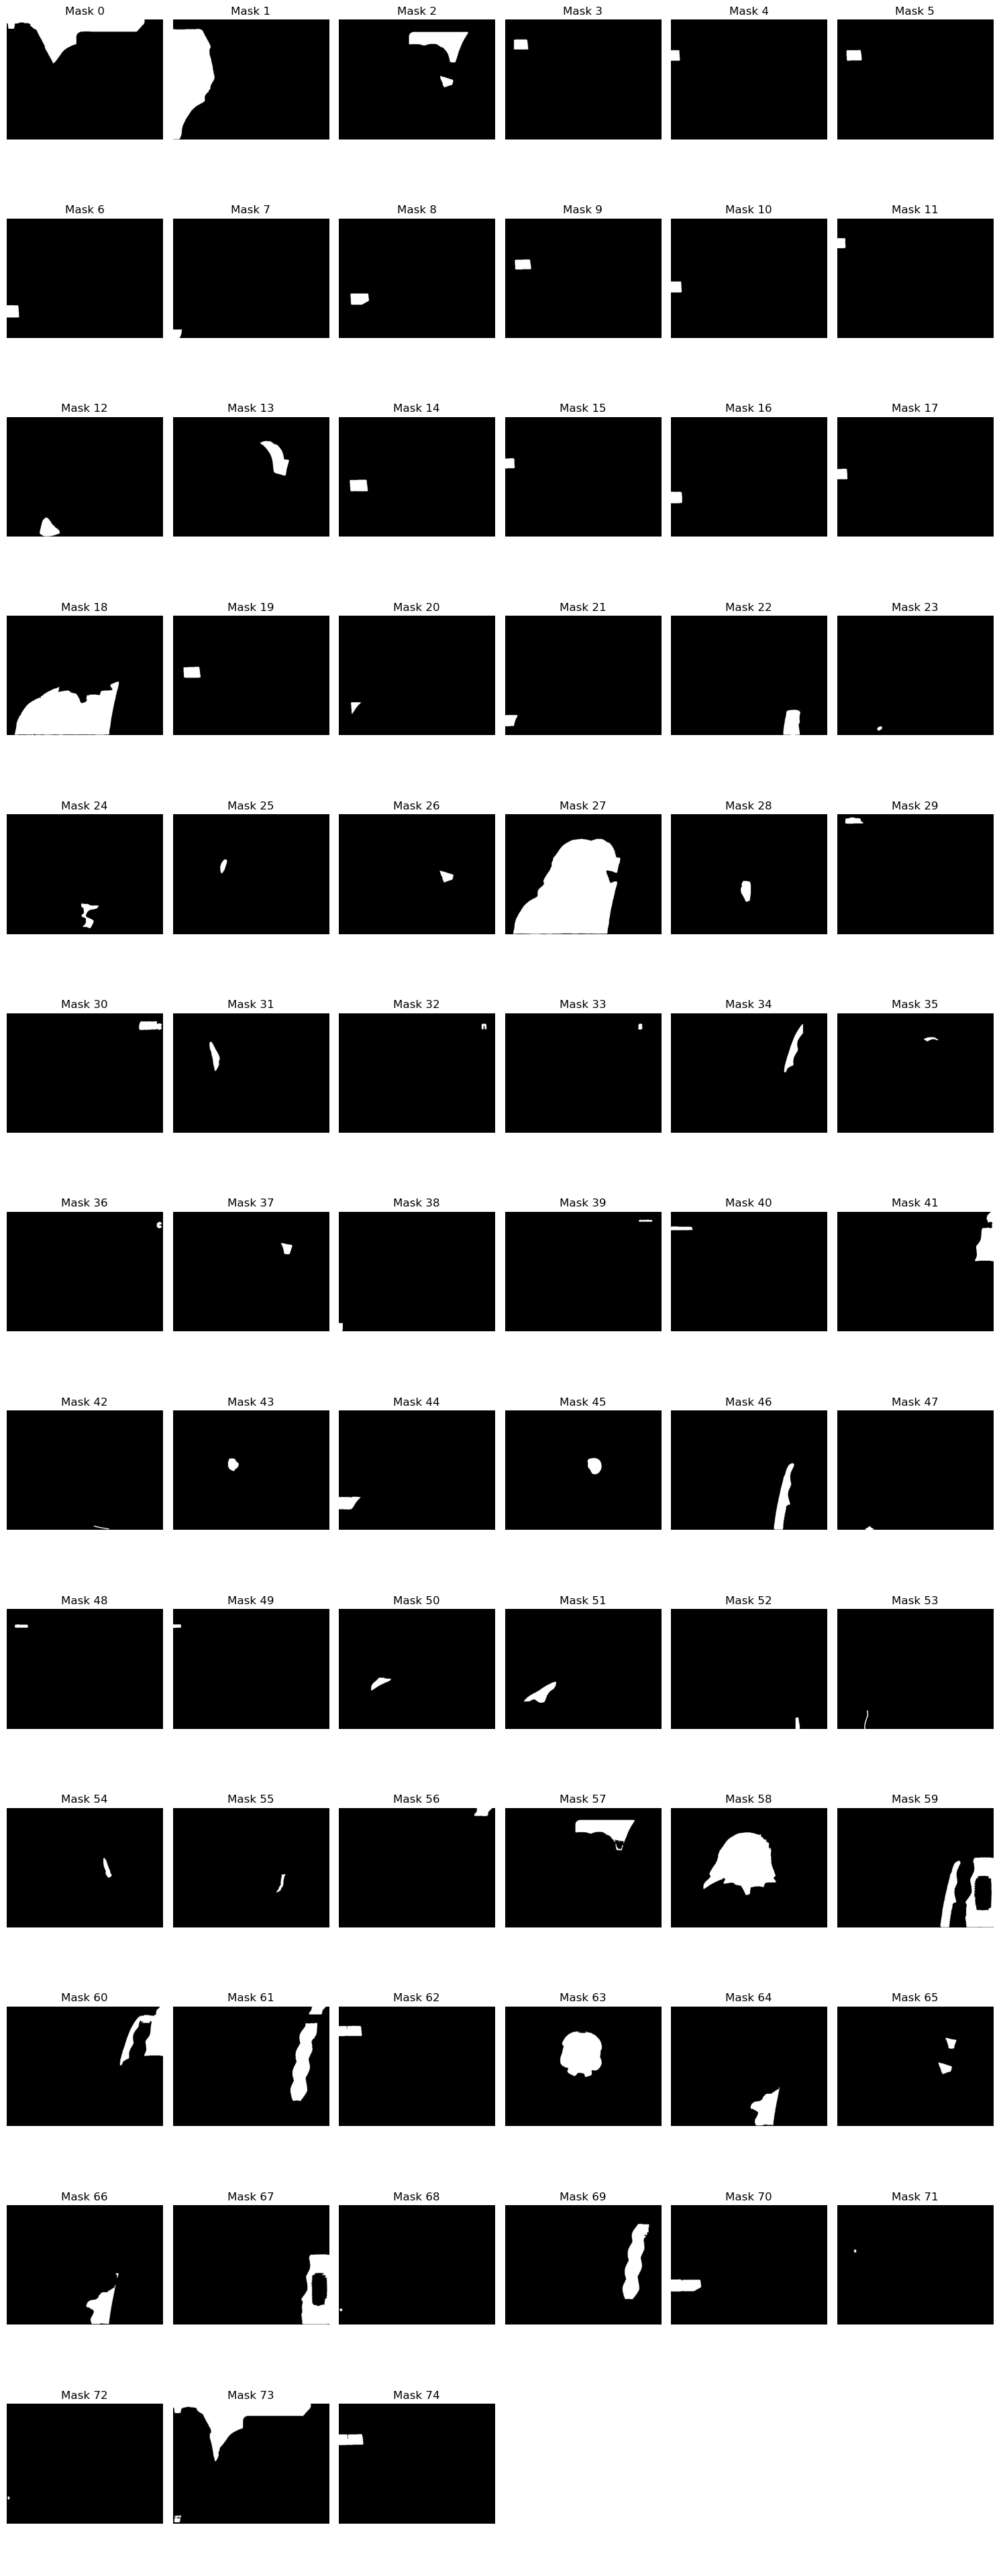

In [188]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks6)
plt.axis('off')
plt.show() 

import numpy as np
import matplotlib.pyplot as plt

# Example: Display the masks in rows with 6 per row
num_masks = len(masks6)
cols = 6  # Number of masks per row
rows = (num_masks + cols - 1) // cols  # Calculate the number of rows needed

print(f"Number of masks: {num_masks}, Rows: {rows}, Cols: {cols}")

if num_masks == 0:
    print("Warning: No masks available to display.")

fig, axes = plt.subplots(max(1, rows), cols, figsize=(15, max(1, rows) * 3))

for idx, mask_data in enumerate(masks6):
    segmentation = mask_data['segmentation']

    # Convert boolean mask to uint8 format for visualization
    mask_image = (segmentation.astype(np.uint8)) * 255  # 255 for white, 0 for black

    # Get the row and column index for this subplot
    row = idx // cols
    col = idx % cols

    # Display the mask in the corresponding subplot
    axes[row, col].imshow(mask_image, cmap='gray')
    axes[row, col].set_title(f"Mask {idx}")
    axes[row, col].axis('off')  # Hide axis

# Turn off any empty subplots (if there are fewer masks than grid slots)
for ax in axes.flat[num_masks:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


In [190]:
plt.imsave('/Users/santiagowon/Dropbox/Santiago/01. Maestria/Tesis/11_Project_Analysed_DB/mask_18.png', (masks6[18]['segmentation'].astype(np.uint8)) * 255, cmap='gray')

# Selecting the Right Masks to Re-Do through OpenAI prompt Engineering for interpretation

Send the mask coordinates (bounding box, points, or segmentation coordinates) and let the OpenAI API cross-check the coordinates with the full-color image. You can use the coordinates in a prompt and ask OpenAI to determine whether the masked region belongs to the object of interest (e.g., "the girl").



Processing Mask 1/64


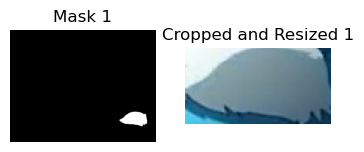

Classification for Mask 1: The cropped image, based on the bounding box coordinates provided ([0.04367902874946594, 0.03283846059229539, 0.010989606380462646, 0.005817098733492327]), represents a very specific and small section of the original image depicting a girl in an outdoor setting.

Given the extremely small dimensions of the cropped region relative to the entire image and considering that the original image contains a girl wearing a jacket and hat in an outdoor setting, we can infer the following:

1. **Image Coordinates and Context**:
   - The coordinates ([0.04367902874946594, 0.03283846059229539, 0.010989606380462646, 0.005817098733492327]) suggest a tiny part of the image. This small section of the image could contain a minute detail, such as a part of the background, a tiny fraction of the girl's clothing, or even a small part of her face or hat, depending on where in the context these coordinates fall.

2. **Probability Analysis**:
   - Since the cropped region is minute,

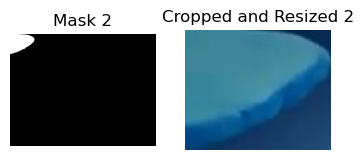

Classification for Mask 2: Based on the provided base64-encoded string and its conversion to an image, the cropped color image encompassing the bounding box coordinates [0, 0, 104, 85] from the original image shows part of the girl's face. More specifically, it likely includes facial features such as the forehead, eyes, and possibly the upper part of her nose or hat brim. Given this close-up, we can infer the following points:

1. **Part of the Girl**: The region corresponds to the upper section of the girl's head. 
2. **Clothing Detail**: It may include part of her hat if it extends down to the forehead.
3. **Background Absence**: Since the bounding box focuses on the top region of her head, it is less likely to include background elements, particularly if the bounding box is tightly cropped around her face.

Thus, this cropped image predominantly represents a part of the girl's head, including facial features and potentially some part of her hat, rather than her clothing or backgroun

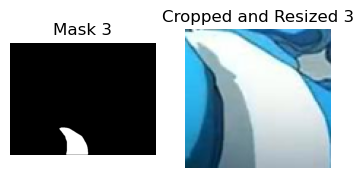

Classification for Mask 3: The cropped image corresponds to the bounding box coordinates [212, 362, 122, 116] taken from a larger image showing a girl wearing a jacket and a hat in an outdoor setting. Given these coordinates, let's analyze what the cropped region likely depicts.

1. **Coordinates Evaluation**:
    - The coordinates [212, 362, 122, 116] suggest that the region is relatively close to the middle or lower part of the image, often aligning with the torso or lower section of a typical portrait.

2. **Clothing Context**:
    - If the girl is wearing a jacket, the region might capture part of the jacket along with possible details like zippers, fabric texture, or patterns on the jacket.
    - Given the coordinates' relative central position, it's unlikely to capture her face (which would be higher up).

3. **Background vs. Clothing**:
    - If the region captures part of the background, it might include elements like foliage, landscape, or sky, considering it’s an outdoor sett

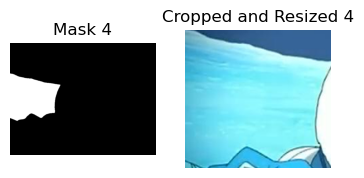

KeyboardInterrupt: 

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io
import base64
import openai
from skimage.measure import label, regionprops

# Resize the original image
def resize_image(image_array, max_size=(512, 512)):
    resized_image = Image.fromarray(image_array)
    resized_image.thumbnail(max_size)  # Resize while keeping aspect ratio
    return np.array(resized_image)  # Convert back to a NumPy array

# Crop the image using the mask before resizing
def crop_image_using_mask(image, mask):
    # Label connected regions in the mask
    labeled_mask = label(mask)
    
    # Get properties of the labeled regions (bounding box, area, etc.)
    regions = regionprops(labeled_mask)
    
    # Find the bounding box of the largest region
    if regions:
        largest_region = max(regions, key=lambda r: r.area)
        min_row, min_col, max_row, max_col = largest_region.bbox

        # Crop the image using the bounding box
        cropped_image = image[min_row:max_row, min_col:max_col]
        return cropped_image
    else:
        print("No regions found in the mask.")
        return None

# Resize the cropped image based on the resized original image proportions
def resize_cropped_image(original_image_size, resized_image_size, cropped_image):
    # Calculate the scaling factor between the original and resized images
    scale_y = resized_image_size[0] / original_image_size[0]
    scale_x = resized_image_size[1] / original_image_size[1]
    
    # Resize the cropped image proportionally
    cropped_resized_image = Image.fromarray(cropped_image)
    cropped_resized_image = cropped_resized_image.resize(
        (int(cropped_resized_image.size[0] * scale_x), int(cropped_resized_image.size[1] * scale_y)),
        Image.LANCZOS
    )
    return cropped_resized_image

# This function sends the resized cropped image to the OpenAI API.
def encode_and_send_image(cropped_image, mask_data, original_image_desc, max_tokens=8192, model="gpt-4o"):
    if cropped_image is None:
        print("Error: Unable to process mask. No valid regions found.")
        return "Error: No valid regions found."
    
    # Convert the resized cropped image to base64
    buffer = io.BytesIO()
    cropped_image.save(buffer, format="PNG")
    encoded_image = base64.b64encode(buffer.getvalue()).decode("utf-8")

    # Create a better prompt for the GPT-4 API
    original_bbox = mask_data['bbox']
    prompt = (f"Look at this cropped image from a larger scene and describe what it shows. "
              f"The cropped region corresponds to the following bounding box coordinates from the original image: {original_bbox}. "
              f"The original image depicts a girl. The original image description is as follows: {original_image_desc}. "
              f"Based on the cropped region, is this part of the girl, part of her clothing, or part of the background? "
              f"Provide a detailed explanation of what this region represents.")

    # Send the image and prompt to GPT-4 API and wait for the response
    return send_to_openai_api(encoded_image, prompt, model)

# Function to display the mask, the cropped image, and print the OpenAI response
def visualize_masks_with_responses(image, masks6, original_image_desc, max_image_size=(512, 512)):
    num_masks = len(masks6)
    
    if num_masks == 0:
        print("Warning: No masks available to display.")
        return

    # Resize the original image first
    original_image_size = image.shape[:2]
    resized_image = resize_image(image, max_size=max_image_size)
    resized_image_size = resized_image.shape[:2]
    
    for idx, mask_data in enumerate(masks6):
        print(f"Processing Mask {idx + 1}/{num_masks}")
        
        # Extract segmentation mask
        segmentation = mask_data['segmentation']
        
        # Convert boolean mask to uint8 format for visualization
        mask_image = (segmentation.astype(np.uint8)) * 255
        
        # Display the original mask
        plt.subplot(1, 3, 1)
        plt.imshow(mask_image, cmap='gray')
        plt.title(f"Mask {idx + 1}")
        plt.axis('off')

        # Crop the image using the mask
        cropped_image = crop_image_using_mask(image, mask_data['segmentation'])
        
        # Resize the cropped image based on the resized image dimensions
        if cropped_image is not None:
            resized_cropped_image = resize_cropped_image(original_image_size, resized_image_size, cropped_image)
            
            # Display the resized cropped image
            plt.subplot(1, 3, 2)
            plt.imshow(resized_cropped_image)
            plt.title(f"Cropped and Resized {idx + 1}")
            plt.axis('off')
        else:
            print(f"No valid regions found in Mask {idx + 1}")
            continue
        
        plt.show()  # Show the mask and cropped image

        # Send to OpenAI GPT-4 API and wait for the response
        classification = encode_and_send_image(resized_cropped_image, mask_data, original_image_desc)
        
        # Print the GPT-4 response for the mask
        print(f"Classification for Mask {idx + 1}: {classification}")
        print("=" * 50)

# Example usage (assuming 'image' is your input image and 'masks6' is your list of masks):
# You can describe the original image here, which gives context to OpenAI
original_image_desc = "The image shows a girl wearing a jacket and a hat in an outdoor setting."
visualize_masks_with_responses(image, masks6, original_image_desc, max_image_size=(512, 512))


# In Painting with Stability AI based on the Masks from SAM